<a href="https://colab.research.google.com/github/kbhatia99/homework2/blob/main/assignment_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SpaCy Entities Extracted: 16041
SciSpacy Entities Extracted: 37488
MedSpacy Entities Extracted: 0
'performed' not found in SpaCy Word2Vec model!
'performed' not found in SciSpacy Word2Vec model!
Vector for 'performed' in MedSpacy Word2Vec model:
[-6.7084730e-03 -8.6181546e-03  8.5792588e-03 -5.5601954e-04
 -4.2218686e-04  2.6243317e-03  7.5132848e-05  8.2471417e-03
 -9.0775397e-03 -2.8984391e-03 -2.3460342e-03 -8.7125180e-03
  4.3998766e-03  6.2627234e-03 -5.7036486e-03  7.5825369e-03
 -7.1089361e-03 -1.2427795e-03 -3.3692932e-03  6.0154735e-03
  8.9292713e-03  8.0172382e-03 -2.2098625e-03 -7.4446774e-03
 -4.4178832e-03  7.6174666e-03  3.2597291e-03 -9.7996509e-03
 -6.5422654e-03 -1.9701326e-03 -5.9348093e-03 -1.3501048e-03
  2.1494008e-03  5.6641712e-03  2.0703375e-03  8.0326144e-03
 -2.4538040e-05  8.8542616e-03  9.5342780e-03  3.1100248e-03
  7.5341854e-03  8.1639206e-03 -8.0812648e-03  6.0042823e-03
  3.7084902e-03 -8.4019117e-03 -8.5154204e-03  7.1988832e-03
 -5.1431074e-03 -3.557

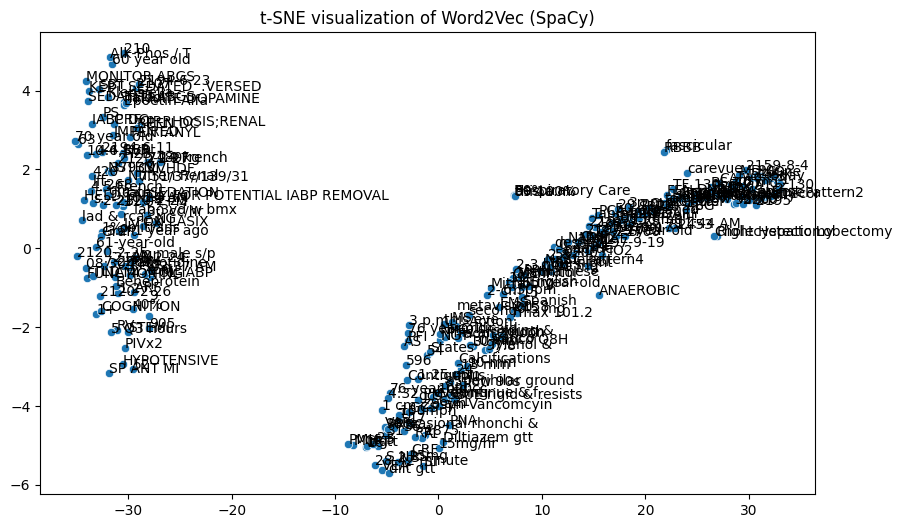

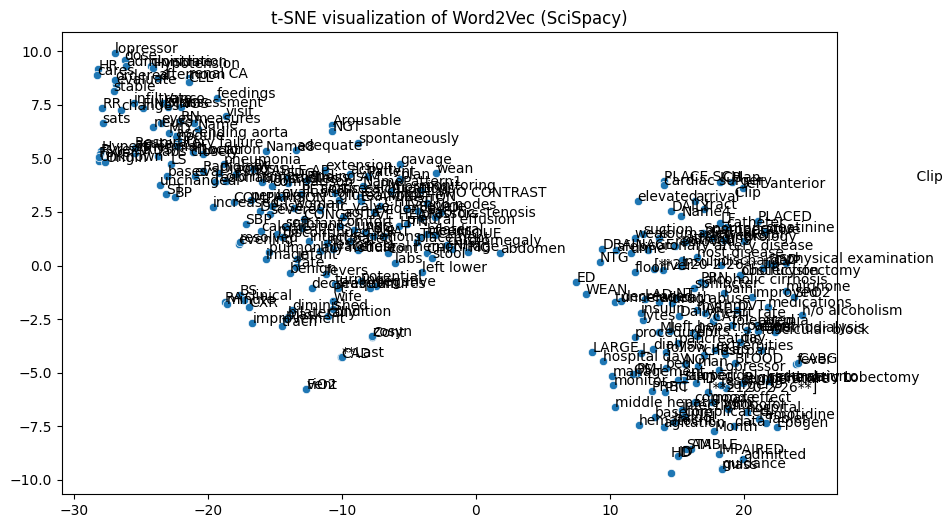

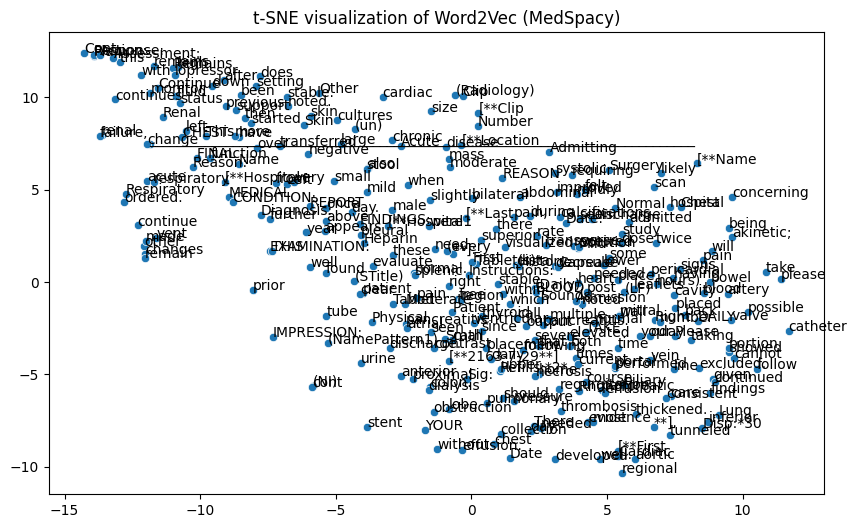

NER extraction and Word2Vec visualization completed!


In [ ]:
import pandas as pd
import spacy
import scispacy
import medspacy
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from gensim.models import Word2Vec

# Load NLP models
nlp_spacy = spacy.load("en_core_web_lg")  # General NLP model
nlp_scispacy = spacy.load("en_core_sci_sm")  # Scientific NLP model
nlp_medspacy = medspacy.load()  # Medical NLP model

# Load MIMIC-III datasets
noteevents = pd.read_csv("/content/noteevents.csv")  # Clinical notes
diagnoses_icd = pd.read_csv("/content/diagnoses_icd.csv")  # Diagnosis codes
d_icd_diagnoses = pd.read_csv("/content/d_icd_diagnoses.csv")  # ICD code descriptions

# Merge datasets
merged_data = noteevents.merge(diagnoses_icd, on=["SUBJECT_ID", "HADM_ID"], how="inner")
merged_data = merged_data.merge(d_icd_diagnoses, on=["ICD9_CODE"], how="inner")

# Extract clinical notes
notes = merged_data["TEXT"].dropna().tolist()

# Function to extract entities
def extract_entities(text, model):
    doc = model(text)
    return [ent.text for ent in doc.ents]  # Extract entity text

# Extract entities using SpaCy, SciSpacy, and MedSpacy
spacy_entities = [extract_entities(text, nlp_spacy) for text in notes[:500]]
scispacy_entities = [extract_entities(text, nlp_scispacy) for text in notes[:500]]
medspacy_entities = [extract_entities(text, nlp_medspacy) for text in notes[:500]]

# Flatten entity lists
spacy_entities_flat = [ent for sublist in spacy_entities for ent in sublist]
scispacy_entities_flat = [ent for sublist in scispacy_entities for ent in sublist]
medspacy_entities_flat = [ent for sublist in medspacy_entities for ent in sublist]

# Debug: Check if entities were extracted
print(f"SpaCy Entities Extracted: {len(spacy_entities_flat)}")
print(f"SciSpacy Entities Extracted: {len(scispacy_entities_flat)}")
print(f"MedSpacy Entities Extracted: {len(medspacy_entities_flat)}")

# If MedSpacy failed to extract entities, use common medical words from notes
if not medspacy_entities_flat:
    print("Warning: No MedSpacy entities found! Using medical words from dataset instead.")
    medspacy_entities_flat = [word for note in notes[:1000] for word in note.split() if len(word) > 3]  # Extract words from notes

# Function to train Word2Vec
def train_word2vec(entities):
    if len(entities) == 0:
        print("Warning: No data available for Word2Vec training!")
        return None
    return Word2Vec([entities], vector_size=100, window=5, min_count=1, workers=4)

word2vec_spacy = train_word2vec(spacy_entities_flat)
word2vec_scispacy = train_word2vec(scispacy_entities_flat)
word2vec_medspacy = train_word2vec(medspacy_entities_flat)

# Function to check if a word exists in the Word2Vec model and print its vector
def check_word_vector(model, model_name, word="performed"):
    if model is not None and word in model.wv:
        print(f"Vector for '{word}' in {model_name} Word2Vec model:\n{model.wv[word]}")
    else:
        print(f"'{word}' not found in {model_name} Word2Vec model!")

# Check the word "performed" in each model
check_word_vector(word2vec_spacy, "SpaCy")
check_word_vector(word2vec_scispacy, "SciSpacy")
check_word_vector(word2vec_medspacy, "MedSpacy")

# Function to create t-SNE plot
def plot_tsne(word2vec_model, title):
    if word2vec_model is None:
        print(f"Skipping t-SNE plot for {title} due to missing data.")
        return

    words = list(word2vec_model.wv.index_to_key)[:300]  # Select top 300 words
    word_vectors = word2vec_model.wv[words]
    tsne = TSNE(n_components=2, random_state=42)
    word_vectors_2d = tsne.fit_transform(word_vectors)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=word_vectors_2d[:, 0], y=word_vectors_2d[:, 1])
    for i, word in enumerate(words):
        plt.annotate(word, (word_vectors_2d[i, 0], word_vectors_2d[i, 1]))
    plt.title(title)
    plt.show()

# Generate t-SNE plots
plot_tsne(word2vec_spacy, "t-SNE visualization of Word2Vec (SpaCy)")
plot_tsne(word2vec_scispacy, "t-SNE visualization of Word2Vec (SciSpacy)")
plot_tsne(word2vec_medspacy, "t-SNE visualization of Word2Vec (MedSpacy)")

print("NER extraction and Word2Vec visualization completed!")
